In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ------------------ 1. Load and Preprocess Data ------------------
file_path = "/content/drive/MyDrive/keepup project methodology code/Final dataset.xlsx"
xls = pd.ExcelFile(file_path)
posts_df = xls.parse("post features")
comments_df = xls.parse("comments")

In [4]:
# Clean and merge
comments_df = comments_df[['post-id', 'commenttext', 'comment label']].dropna()
posts_df = posts_df[['post-id', 'post-title', 'post-label']].dropna()


In [5]:
# Filter comments to only those with valid post_ids
data = comments_df.merge(posts_df, on="post-id")
data = data[data['comment label'].isin(['agree', 'disagree', 'query', 'comment'])]

In [6]:
# Encode stance labels
stance_le = LabelEncoder()
data['stance_label'] = stance_le.fit_transform(data['comment label'])

In [7]:
# Encode veracity labels (1: fake, 0: true)
veracity_le = LabelEncoder()
data['veracity_label'] = veracity_le.fit_transform(data['post-label'])

#Dual Bi-LSTM-GRU based stance detection in tweets ordered classes

In [8]:
!pip install torch nltk scikit-learn pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# Load GloVe
def load_glove(path="glove.6B.100d.txt"):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec
    return embeddings

In [10]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Embed a document using average of GloVe vectors
def embed_document(text, embeddings, dim=100):
    tokens = word_tokenize(text.lower(), preserve_line=True) # Set preserve_line to True
    vectors = [embeddings[token] for token in tokens if token in embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Step 1: Combine title and comment into one field
# Ensure both columns are strings before concatenation
data['text'] = data['post-title'].astype(str) + " " + data['commenttext'].astype(str)

In [12]:
# Define the dimension of GloVe embeddings
dim = 100
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

glove_path = "glove.6B.100d.txt"
glove = load_glove(glove_path)

print("✅ GloVe embeddings loaded.")

--2025-06-26 16:04:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-26 16:04:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-26 16:04:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [13]:
 #Step 2: Apply embedding using GloVe
data["embedding"] = data["text"].apply(lambda x: embed_document(x, glove, dim))

# Step 3: Prepare X and y
X = np.stack(data["embedding"].values)
y = data["stance_label"].values

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
class StanceEmbedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # Add sequence dim


In [15]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=4):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time-step
        return self.fc(out)


In [18]:
# Dataset and Dataloader
train_dataset = StanceEmbedDataset(X_train, y_train)
test_dataset = StanceEmbedDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
model = BiLSTMClassifier(input_dim=dim, num_classes=4)  # Make sure `dim` is your embedding size

# Force CPU
device = torch.device("cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"📅 Epoch {epoch+1}, Loss: {total_loss:.4f}")


📅 Epoch 1, Loss: 252.9204
📅 Epoch 2, Loss: 238.1424
📅 Epoch 3, Loss: 230.6730
📅 Epoch 4, Loss: 226.7880
📅 Epoch 5, Loss: 223.3110
📅 Epoch 6, Loss: 220.6846
📅 Epoch 7, Loss: 217.0426
📅 Epoch 8, Loss: 214.7126
📅 Epoch 9, Loss: 212.8676
📅 Epoch 10, Loss: 210.7707


In [19]:
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')

    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall:    {rec:.4f}")

evaluate(model, test_loader)


✅ Accuracy:  0.5870
✅ F1 Score:  0.3913
✅ Precision: 0.6407
✅ Recall:    0.3788


#Dual Bi-LSTM-GRU based stance detection in tweets ordered classes

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [21]:
# ------------------- Step 1: Load GloVe Embeddings -------------------
def load_glove_embeddings(glove_path, embedding_dim=100):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            if len(vector) == embedding_dim:
                embeddings[word] = vector
    return embeddings

glove_path = "glove.6B.100d.txt"  # <-- Download required
glove = load_glove_embeddings(glove_path, embedding_dim=100)

In [22]:
# ------------------- Step 2: Preprocessing -------------------
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

def text_to_embedding(text, glove, max_len=30, embedding_dim=100):
    tokens = clean_text(text).split()
    embed = []
    for token in tokens[:max_len]:
        vec = glove.get(token, np.zeros(embedding_dim))
        embed.append(vec)
    while len(embed) < max_len:
        embed.append(np.zeros(embedding_dim))
    return np.array(embed)


In [31]:
# ------------------- Step 3: Dataset Class -------------------
class SentenceLevelDataset(Dataset):
    def __init__(self, tweets, replies, labels, glove, max_len=30, dim=100):
        self.tweets = tweets
        self.replies = replies
        self.labels = labels
        self.glove = glove
        self.max_len = max_len
        self.dim = dim

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet_embed = text_to_embedding(self.tweets[idx], self.glove, self.max_len, self.dim)
        reply_embed = text_to_embedding(self.replies[idx], self.glove, self.max_len, self.dim)
        return torch.tensor(tweet_embed, dtype=torch.float32), torch.tensor(reply_embed, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long) # Explicitly cast to float32

In [36]:
# ------------------- Step 4: Sentence-Level LSTM Model -------------------
class SentenceLSTMClassifier(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=64, num_classes=4): # Changed num_classes to 4
        super(SentenceLSTMClassifier, self).__init__()
        self.tweet_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.reply_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 64)
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, num_classes)

    def forward(self, tweet, reply):
        _, (h_tweet, _) = self.tweet_lstm(tweet)
        _, (h_reply, _) = self.reply_lstm(reply)

        z = torch.cat((h_tweet[-1], h_reply[-1]), dim=1)  # [batch, hidden_dim*2]
        z = self.dropout(z)
        z = self.bn(z)
        z = self.relu(self.fc(z))
        return self.out(z)

In [37]:
comments_df

,post-id,commenttext,comment label
0,1.0,انعام انعام ہی ہوتا ہے چاہیے کھجور کی گٹھلی ہی...,agree
1,1.0,کھجور کی گھٹلی دے دیتے بہتر تھا. یہ تو لگ رہا ...,disagree
2,1.0,انعام انعام ہی ہوتا ہے چاہے 🇳🇪 ہی ہو۔۔۔۔,agree
3,1.0,tujhey gutli hi miley,comment
4,1.0,Cash de detey,comment
...,...,...,...
69524,1024.0,Worse thing happened in years,Agree
69525,1024.0,Indian government is trying hard to create con...,Disagree
69526,1024.0,The Print is doing excellent job to showcase h...,Agree
69527,1024.0,Why the innocent people?,Query


In [38]:
# ------------------- Step 5: Real Data Setup -------------------
# Make sure your dataframe is loaded as `data` and has these columns:
# 'text', 'stance_label'

# Optional: Clean any NaNs
data = data.dropna(subset=["text", "stance_label"])

# Convert to expected structure (using already encoded 'stance_label')
# data = data.rename(columns={"post-title": "tweet", "commenttext": "reply"}) # No need to rename if using 'text'

# Ensure correct types
data["text"] = data["text"].astype(str)
# The 'stance_label' column is already numerical, no need to convert to int

# Check class distribution
print(data["stance_label"].value_counts())

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data["text"], # Use the combined 'text' column
    data["stance_label"], # Use the already encoded 'stance_label'
    test_size=0.2, # Changed test_size to 0.2 for consistency with other models
    random_state=42,
    stratify=data["stance_label"] # Stratify by 'stance_label'
)

# Dataset and Dataloader
# Assuming 'glove' and 'dim' are defined in the environment
train_dataset = SentenceLevelDataset(X_train.values, X_train.values, y_train.values, glove) # Use X_train.values for both tweet and reply
test_dataset = SentenceLevelDataset(X_test.values, X_test.values, y_test.values, glove) # Use X_test.values for both tweet and reply

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Changed batch_size to 16
test_loader = DataLoader(test_dataset, batch_size=16) # Changed batch_size to 16

stance_label
1    17925
0    12697
2     3107
3     2657
Name: count, dtype: int64


In [39]:
# ------------------- Step 6: Train Model -------------------
device = torch.device("cpu")
model = SentenceLSTMClassifier().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for tweet, reply, label in train_loader:
        tweet, reply, label = tweet.to(device), reply.to(device), label.to(device)

        outputs = model(tweet, reply)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"📅 Epoch {epoch+1}, Loss: {total_loss:.4f}")

📅 Epoch 1, Loss: 2048.6264
📅 Epoch 2, Loss: 1957.7755
📅 Epoch 3, Loss: 1854.6783
📅 Epoch 4, Loss: 1817.5224
📅 Epoch 5, Loss: 1773.0312


In [40]:
# ------------------- Step 7: Evaluate -------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for tweet, reply, label in test_loader:
        tweet, reply = tweet.to(device), reply.to(device)
        outputs = model(tweet, reply)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.numpy())

print("\n📊 Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["agree", "disagree", "query", "comment"]))


📊 Evaluation Report:
              precision    recall  f1-score   support

       agree       0.74      0.40      0.52      2540
    disagree       0.57      0.91      0.70      3585
       query       0.67      0.19      0.30       622
     comment       0.00      0.00      0.00       531

    accuracy                           0.61      7278
   macro avg       0.50      0.38      0.38      7278
weighted avg       0.60      0.61      0.55      7278



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Stanceformer: Target-Aware Transformer for Stance Detection

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
#from transformers.optimization import AdamW # Import AdamW from transformers.optimization
from sklearn.model_selection import train_test_split
import pandas as pd

In [46]:
# Restore original data loading and preprocessing
file_path = "/content/drive/MyDrive/keepup project methodology code/Final dataset.xlsx"
xls = pd.ExcelFile(file_path)
posts_df = xls.parse("post features")
comments_df = xls.parse("comments")

# Clean and merge
comments_df = comments_df[['post-id', 'commenttext', 'comment label']].dropna()
posts_df = posts_df[['post-id', 'post-title', 'post-label']].dropna()

# Filter comments to only those with valid post_ids
data = comments_df.merge(posts_df, on="post-id")
data = data[data['comment label'].isin(['agree', 'disagree', 'query', 'comment'])]

# Encode stance labels
stance_le = LabelEncoder()
data['stance_label'] = stance_le.fit_transform(data['comment label'])

# Encode veracity labels (1: fake, 0: true)
veracity_le = LabelEncoder()
data['veracity_label'] = veracity_le.fit_transform(data['post-label'])

# Keep the dummy data creation for testing purposes, ensuring consistent length
# data = pd.DataFrame({
#     "post-title": ["Economy boosts GDP", "Boring cricket match"] * 100,
#     "commenttext": ["This is great news!", "It was so dull."] * 100,
#     "stance_label": [0, 1, 2, 3] * 50 # Adjusted length to match other columns
# })

In [47]:
data['post-title'] = data['post-title'].astype(str)
data['commenttext'] = data['commenttext'].astype(str)
data['text'] = data['post-title'] + " " + data['commenttext']

In [54]:
# ------------------- Step 5: Prepare for Training -------------------
X = data[["post-title", "text"]]  # target (title), input (title + comment)
y = data["stance_label"] # Changed to use the numerical 'stance_label'

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [61]:
# ------------------- Dataset Class -------------------
class StanceformerDataset(Dataset):
    def __init__(self, targets, texts, labels, tokenizer, max_len=128):
        self.targets = targets
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_text = self.texts[idx]
        target_text = self.targets[idx]
        encoding = self.tokenizer(
            input_text,
            target_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item


In [62]:
# ------------------- Tokenizer Setup -------------------
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = StanceformerDataset(
    targets=X_train['post-title'].tolist(),
    texts=X_train['text'].tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer
)

test_dataset = StanceformerDataset(
    targets=X_test['post-title'].tolist(),
    texts=X_test['text'].tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [63]:
# ------------------- Step 6: Define Stanceformer Model -------------------
import torch.nn as nn
from transformers import BertModel

class StanceformerModel(nn.Module):
    def __init__(self, num_labels=3):
        super(StanceformerModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [ ]:
# ------------------- Step 7: Train the Model -------------------
model = StanceformerModel(num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, Loss: 490.2565


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [ ]:
# ------------------- Step 8: Evaluate the Model -------------------
model.eval()
preds = []
true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)

        preds.extend(predictions.cpu().numpy())
        true.extend(labels.cpu().numpy())

print("\nClassification Report on Test Set:")
print(classification_report(true, preds, digits=4))

In [ ]:
#LSTM

In [ ]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")


In [ ]:
# ------------------ 2. Define Dataset ------------------
class StanceDataset(Dataset):
    def __init__(self, titles, comments, labels, tokenizer, max_len=512):
        self.titles = titles
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.titles[idx]), str(self.comments[idx]),
            padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
# ------------------ 3. Define LSTM-Only Stance Model ------------------
class LSTMStanceModel(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=4):
        super(LSTMStanceModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        pooled = torch.mean(x, dim=1)
        return self.fc(pooled)


In [ ]:
# ------------------ 4. Train Stance Model ------------------
import warnings
from tqdm import tqdm
from transformers.utils import logging
logging.set_verbosity_error()  # Hides tokenizer warnings

warnings.filterwarnings("ignore")  # Suppress warnings

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[['post-title', 'commenttext']], data['stance_label'], test_size=0.2, random_state=42)

train_dataset = StanceDataset(
    train_texts['post-title'].values,
    train_texts['commenttext'].values,
    train_labels.values,
    tokenizer,
    max_len=512
)
val_dataset = StanceDataset(
    val_texts['post-title'].values,
    val_texts['commenttext'].values,
    val_labels.values,
    tokenizer,
    max_len=512
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

stance_model = LSTMStanceModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stance_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stance_model.parameters(), lr=2e-5)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch + 1}/{num_epochs} - Training started...")

    stance_model.train()
    for batch in tqdm(train_loader, desc=f"🔄 Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = stance_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"✅ Epoch {epoch + 1} completed.")
    print(f"📌 Remaining epochs: {num_epochs - (epoch + 1)}")



📅 Epoch 1/5 - Training started...


🔄 Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:14<00:00,  2.43it/s]


✅ Epoch 1 completed.
📌 Remaining epochs: 4

📅 Epoch 2/5 - Training started...


🔄 Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:13<00:00,  2.43it/s]


✅ Epoch 2 completed.
📌 Remaining epochs: 3

📅 Epoch 3/5 - Training started...


🔄 Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:06<00:00,  2.48it/s]


✅ Epoch 3 completed.
📌 Remaining epochs: 2

📅 Epoch 4/5 - Training started...


🔄 Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:06<00:00,  2.49it/s]


✅ Epoch 4 completed.
📌 Remaining epochs: 1

📅 Epoch 5/5 - Training started...


🔄 Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:06<00:00,  2.48it/s]

✅ Epoch 5 completed.
📌 Remaining epochs: 0


In [ ]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers.utils import logging

📊 Training Set Evaluation:
✅ Accuracy:  0.5590
✅ F1 Score:  0.3030
✅ Precision: 0.3280
✅ Recall:    0.3338
📊 Validation Set Evaluation:
✅ Accuracy:  0.5559
✅ F1 Score:  0.3000
✅ Precision: 0.2761
✅ Recall:    0.3301


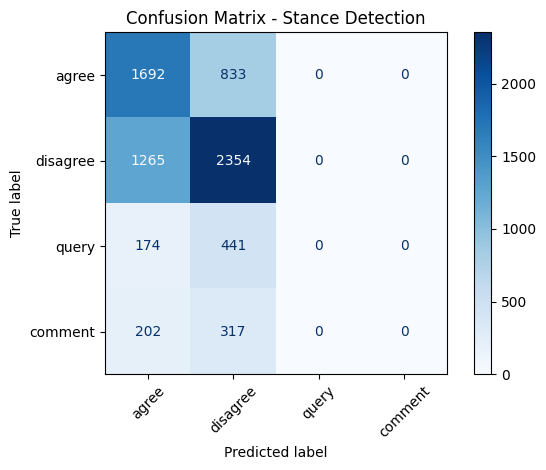

In [ ]:
# ------------------ 6. Evaluation ------------------
def evaluate_model(dataloader, dataset_name):
    stance_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = stance_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"📊 {dataset_name} Evaluation:")
    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")

    if dataset_name == "Validation Set":
        label_names = ["agree", "disagree", "query", "comment"]
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title("Confusion Matrix - Stance Detection")
        plt.tight_layout()
        plt.show()

# Evaluate on training and validation sets
evaluate_model(train_loader, "Training Set")
evaluate_model(val_loader, "Validation Set")

In [ ]:
#RNN

In [ ]:
# ------------------ 2. Dataset Class ------------------
class StanceDataset(Dataset):
    def __init__(self, titles, comments, labels, tokenizer, max_len=512):
        self.titles = titles
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.titles[idx]), str(self.comments[idx]),
            padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# ------------------ 3. RNN-Based Stance Model ------------------
class RNNStanceModel(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=4):
        super(RNNStanceModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.rnn = nn.RNN(input_size=768, hidden_size=hidden_dim,
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze RoBERTa
            x = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        rnn_output, _ = self.rnn(x)
        pooled = torch.mean(rnn_output, dim=1)
        return self.fc(pooled)

In [ ]:
# ------------------ 4. Train Stance Model ------------------
import warnings
from tqdm import tqdm
from transformers.utils import logging
logging.set_verbosity_error()  # Hides tokenizer warnings

warnings.filterwarnings("ignore")  # Suppress warnings

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[['post-title', 'commenttext']], data['stance_label'], test_size=0.2, random_state=42)

train_dataset = StanceDataset(
    train_texts['post-title'].values,
    train_texts['commenttext'].values,
    train_labels.values,
    tokenizer,
    max_len=512
)
val_dataset = StanceDataset(
    val_texts['post-title'].values,
    val_texts['commenttext'].values,
    val_labels.values,
    tokenizer,
    max_len=512
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

stance_model = RNNStanceModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stance_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stance_model.parameters(), lr=2e-5)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch + 1}/{num_epochs} - Training started...")

    stance_model.train()
    for batch in tqdm(train_loader, desc=f"🔄 Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = stance_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"✅ Epoch {epoch + 1} completed.")
    print(f"📌 Remaining epochs: {num_epochs - (epoch + 1)}")



📅 Epoch 1/5 - Training started...


🔄 Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 910/910 [05:16<00:00,  2.87it/s]


✅ Epoch 1 completed.
📌 Remaining epochs: 4

📅 Epoch 2/5 - Training started...


🔄 Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 910/910 [05:16<00:00,  2.87it/s]


✅ Epoch 2 completed.
📌 Remaining epochs: 3

📅 Epoch 3/5 - Training started...


🔄 Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 910/910 [05:16<00:00,  2.87it/s]


✅ Epoch 3 completed.
📌 Remaining epochs: 2

📅 Epoch 4/5 - Training started...


🔄 Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 910/910 [05:16<00:00,  2.87it/s]


✅ Epoch 4 completed.
📌 Remaining epochs: 1

📅 Epoch 5/5 - Training started...


🔄 Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 910/910 [05:16<00:00,  2.87it/s]

✅ Epoch 5 completed.
📌 Remaining epochs: 0


📊 Training Set Evaluation:
✅ Accuracy:  0.5835
✅ F1 Score:  0.3087
✅ Precision: 0.4718
✅ Recall:    0.3290
📊 Validation Set Evaluation:
✅ Accuracy:  0.5933
✅ F1 Score:  0.3173
✅ Precision: 0.4915
✅ Recall:    0.3341


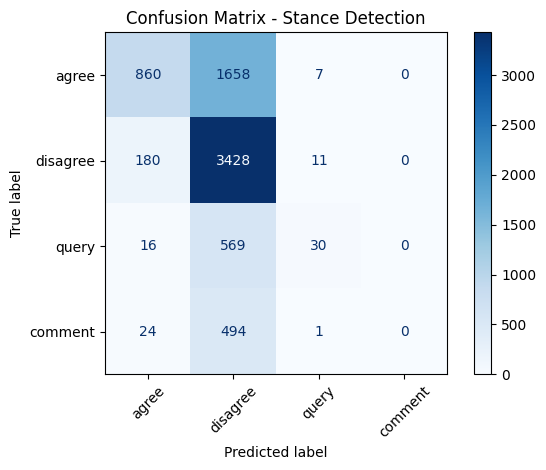

In [ ]:
# ------------------ 6. Evaluation ------------------
def evaluate_model(dataloader, dataset_name):
    stance_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = stance_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"📊 {dataset_name} Evaluation:")
    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")

    if dataset_name == "Validation Set":
        label_names = ["agree", "disagree", "query", "comment"]
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title("Confusion Matrix - Stance Detection")
        plt.tight_layout()
        plt.show()

# Evaluate on training and validation sets
evaluate_model(train_loader, "Training Set")
evaluate_model(val_loader, "Validation Set")

In [ ]:
#BERT

In [ ]:
from transformers import BertTokenizer, BertModel
# ------------------ 2. Dataset Class ------------------
class StanceDataset(Dataset):
    def __init__(self, titles, comments, labels, tokenizer, max_len=128):
        self.titles = titles
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.titles[idx]), str(self.comments[idx]),
            padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
# ------------------ 3. Simple BERT Classifier ------------------
class SimpleBERTClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        return self.fc(self.drop(pooled_output))


In [ ]:

import warnings
from tqdm import tqdm
from transformers.utils import logging
logging.set_verbosity_error()  # Hides tokenizer warnings

warnings.filterwarnings("ignore")  # Suppress warnings
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[['post-title', 'commenttext']], data['stance_label'], test_size=0.2, random_state=42)

train_dataset = StanceDataset(
    train_texts['post-title'].values,
    train_texts['commenttext'].values,
    train_labels.values,
    tokenizer
)
val_dataset = StanceDataset(
    val_texts['post-title'].values,
    val_texts['commenttext'].values,
    val_labels.values,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
stance_model = SimpleBERTClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stance_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stance_model.parameters(), lr=2e-5)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch + 1}/{num_epochs} - Training started...")

    stance_model.train()
    for batch in tqdm(train_loader, desc=f"🔄 Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = stance_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"✅ Epoch {epoch + 1} completed.")
    print(f"📌 Remaining epochs: {num_epochs - (epoch + 1)}")


📅 Epoch 1/5 - Training started...


🔄 Epoch 1: 100%|██████████████████████████████████████████████████████████████████| 1820/1820 [04:14<00:00,  7.14it/s]


✅ Epoch 1 completed.
📌 Remaining epochs: 4

📅 Epoch 2/5 - Training started...


🔄 Epoch 2: 100%|██████████████████████████████████████████████████████████████████| 1820/1820 [04:14<00:00,  7.15it/s]


✅ Epoch 2 completed.
📌 Remaining epochs: 3

📅 Epoch 3/5 - Training started...


🔄 Epoch 3: 100%|██████████████████████████████████████████████████████████████████| 1820/1820 [04:14<00:00,  7.15it/s]


✅ Epoch 3 completed.
📌 Remaining epochs: 2

📅 Epoch 4/5 - Training started...


🔄 Epoch 4: 100%|██████████████████████████████████████████████████████████████████| 1820/1820 [04:14<00:00,  7.15it/s]


✅ Epoch 4 completed.
📌 Remaining epochs: 1

📅 Epoch 5/5 - Training started...


🔄 Epoch 5: 100%|██████████████████████████████████████████████████████████████████| 1820/1820 [04:14<00:00,  7.15it/s]

✅ Epoch 5 completed.
📌 Remaining epochs: 0


📊 Training Set Evaluation:
✅ Accuracy:  0.9215
✅ F1 Score:  0.9102
✅ Precision: 0.9249
✅ Recall:    0.8970
📊 Validation Set Evaluation:
✅ Accuracy:  0.7488
✅ F1 Score:  0.7108
✅ Precision: 0.7381
✅ Recall:    0.6891


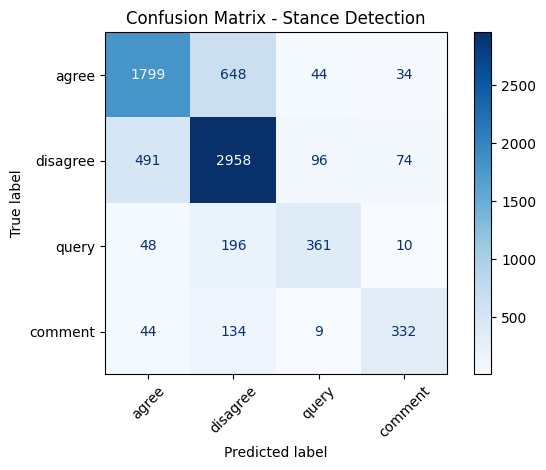

In [ ]:
# ------------------ 6. Evaluation ------------------
def evaluate_model(dataloader, dataset_name):
    stance_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = stance_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"📊 {dataset_name} Evaluation:")
    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")

    if dataset_name == "Validation Set":
        label_names = ["agree", "disagree", "query", "comment"]
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title("Confusion Matrix - Stance Detection")
        plt.tight_layout()
        plt.show()

# Evaluate on training and validation sets
evaluate_model(train_loader, "Training Set")
evaluate_model(val_loader, "Validation Set")

In [ ]:
#Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
# ------------------ 2. Dataset Class ------------------
class StanceDataset(Dataset):
    def __init__(self, titles, comments, labels, tokenizer, max_len=128):
        self.titles = titles
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.titles[idx]), str(self.comments[idx]),
            padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# ------------------ 3. Simple RoBERTa Classifier ------------------
class SimpleRoBERTaClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleRoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return self.classifier(self.dropout(cls_output))


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[['post-title', 'commenttext']], data['stance_label'], test_size=0.2, random_state=42)

train_dataset = StanceDataset(
    train_texts['post-title'].values,
    train_texts['commenttext'].values,
    train_labels.values,
    tokenizer
)
val_dataset = StanceDataset(
    val_texts['post-title'].values,
    val_texts['commenttext'].values,
    val_labels.values,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
# ------------------ 5. Training ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRoBERTaClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch + 1}/{num_epochs}")
    model.train()
    for batch in tqdm(train_loader, desc=f"🔁 Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



📅 Epoch 1/5


🔁 Training: 100%|█████████████████████████████████████████████████████████████████| 1820/1820 [04:20<00:00,  6.99it/s]



📅 Epoch 2/5


🔁 Training: 100%|█████████████████████████████████████████████████████████████████| 1820/1820 [04:20<00:00,  6.99it/s]



📅 Epoch 3/5


🔁 Training: 100%|█████████████████████████████████████████████████████████████████| 1820/1820 [04:20<00:00,  6.99it/s]



📅 Epoch 4/5


🔁 Training: 100%|█████████████████████████████████████████████████████████████████| 1820/1820 [04:20<00:00,  6.99it/s]



📅 Epoch 5/5


🔁 Training: 100%|█████████████████████████████████████████████████████████████████| 1820/1820 [04:20<00:00,  6.99it/s]


In [ ]:
# ------------------ 6. Evaluation ------------------
def evaluate_model(dataloader, name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    prec = precision_score(all_labels, all_preds, average="macro")
    rec = recall_score(all_labels, all_preds, average="macro")

    print(f"\n📊 {name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")

evaluate_model(train_loader, "Training Set")
evaluate_model(val_loader, "Validation Set")


📊 Training Set Results:
Accuracy:  0.8490
F1 Score:  0.8264
Precision: 0.8553
Recall:    0.8034

📊 Validation Set Results:
Accuracy:  0.7520
F1 Score:  0.7188
Precision: 0.7459
Recall:    0.6980


In [ ]:
# ------------------ 2. Define Dataset ------------------
class StanceDataset(Dataset):
    def __init__(self, titles, comments, labels, tokenizer, max_len=512): # Changed max_len to 512
        self.titles = titles
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.titles[idx]), str(self.comments[idx]),
            padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
# ------------------ 3. Define Stance Model ------------------
class StanceModel(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=4):
        super(StanceModel, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.lstm = nn.LSTM(768, hidden_dim, bidirectional=True, batch_first=True)
        self.bigru = nn.GRU(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        # The attention layer should process the output of the BiGRU, which has hidden_dim * 2 features
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x, _ = self.bigru(x)
        # Apply attention to the output of the BiGRU layer
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return self.fc(context)

In [ ]:
# ------------------ 4. Train Stance Model ------------------
import warnings
from tqdm import tqdm
from transformers.utils import logging
logging.set_verbosity_error()  # Hides tokenizer warnings

warnings.filterwarnings("ignore")  # Suppress warnings

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[['post-title', 'commenttext']], data['stance_label'], test_size=0.2, random_state=42)

train_dataset = StanceDataset(
    train_texts['post-title'].values,
    train_texts['commenttext'].values,
    train_labels.values,
    tokenizer,
    max_len=512
)
val_dataset = StanceDataset(
    val_texts['post-title'].values,
    val_texts['commenttext'].values,
    val_labels.values,
    tokenizer,
    max_len=512
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Changed batch_size to 16
val_loader = DataLoader(val_dataset, batch_size=16) # Changed batch_size to 16

stance_model = StanceModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stance_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stance_model.parameters(), lr=2e-5)

num_epochs = 100
for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch + 1}/{num_epochs} - Training started...")

    stance_model.train()
    for batch in tqdm(train_loader, desc=f"🔄 Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = stance_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"✅ Epoch {epoch + 1} completed.")
    print(f"📌 Remaining epochs: {num_epochs - (epoch + 1)}")


📅 Epoch 1/100 - Training started...


🔄 Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:53<00:00,  2.20it/s]


✅ Epoch 1 completed.
📌 Remaining epochs: 99

📅 Epoch 2/100 - Training started...


🔄 Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:52<00:00,  2.21it/s]


✅ Epoch 2 completed.
📌 Remaining epochs: 98

📅 Epoch 3/100 - Training started...


🔄 Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:51<00:00,  2.21it/s]


✅ Epoch 3 completed.
📌 Remaining epochs: 97

📅 Epoch 4/100 - Training started...


🔄 Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:52<00:00,  2.20it/s]


✅ Epoch 4 completed.
📌 Remaining epochs: 96

📅 Epoch 5/100 - Training started...


🔄 Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:52<00:00,  2.21it/s]


✅ Epoch 5 completed.
📌 Remaining epochs: 95

📅 Epoch 6/100 - Training started...


🔄 Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:52<00:00,  2.21it/s]


✅ Epoch 6 completed.
📌 Remaining epochs: 94

📅 Epoch 7/100 - Training started...


🔄 Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:53<00:00,  2.20it/s]


✅ Epoch 7 completed.
📌 Remaining epochs: 93

📅 Epoch 8/100 - Training started...


🔄 Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 8 completed.
📌 Remaining epochs: 92

📅 Epoch 9/100 - Training started...


🔄 Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 910/910 [06:54<00:00,  2.20it/s]


✅ Epoch 9 completed.
📌 Remaining epochs: 91

📅 Epoch 10/100 - Training started...


🔄 Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:54<00:00,  2.19it/s]


✅ Epoch 10 completed.
📌 Remaining epochs: 90

📅 Epoch 11/100 - Training started...


🔄 Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 11 completed.
📌 Remaining epochs: 89

📅 Epoch 12/100 - Training started...


🔄 Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:54<00:00,  2.19it/s]


✅ Epoch 12 completed.
📌 Remaining epochs: 88

📅 Epoch 13/100 - Training started...


🔄 Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 13 completed.
📌 Remaining epochs: 87

📅 Epoch 14/100 - Training started...


🔄 Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 14 completed.
📌 Remaining epochs: 86

📅 Epoch 15/100 - Training started...


🔄 Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:54<00:00,  2.19it/s]


✅ Epoch 15 completed.
📌 Remaining epochs: 85

📅 Epoch 16/100 - Training started...


🔄 Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 16 completed.
📌 Remaining epochs: 84

📅 Epoch 17/100 - Training started...


🔄 Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:50<00:00,  2.22it/s]


✅ Epoch 17 completed.
📌 Remaining epochs: 83

📅 Epoch 18/100 - Training started...


🔄 Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:52<00:00,  2.21it/s]


✅ Epoch 18 completed.
📌 Remaining epochs: 82

📅 Epoch 19/100 - Training started...


🔄 Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 19 completed.
📌 Remaining epochs: 81

📅 Epoch 20/100 - Training started...


🔄 Epoch 20: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:53<00:00,  2.20it/s]


✅ Epoch 20 completed.
📌 Remaining epochs: 80

📅 Epoch 21/100 - Training started...


🔄 Epoch 21: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:49<00:00,  2.22it/s]


✅ Epoch 21 completed.
📌 Remaining epochs: 79

📅 Epoch 22/100 - Training started...


🔄 Epoch 22: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:54<00:00,  2.20it/s]


✅ Epoch 22 completed.
📌 Remaining epochs: 78

📅 Epoch 23/100 - Training started...


🔄 Epoch 23: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 23 completed.
📌 Remaining epochs: 77

📅 Epoch 24/100 - Training started...


🔄 Epoch 24: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 24 completed.
📌 Remaining epochs: 76

📅 Epoch 25/100 - Training started...


🔄 Epoch 25: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 25 completed.
📌 Remaining epochs: 75

📅 Epoch 26/100 - Training started...


🔄 Epoch 26: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 26 completed.
📌 Remaining epochs: 74

📅 Epoch 27/100 - Training started...


🔄 Epoch 27: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 27 completed.
📌 Remaining epochs: 73

📅 Epoch 28/100 - Training started...


🔄 Epoch 28: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 28 completed.
📌 Remaining epochs: 72

📅 Epoch 29/100 - Training started...


🔄 Epoch 29: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 29 completed.
📌 Remaining epochs: 71

📅 Epoch 30/100 - Training started...


🔄 Epoch 30: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 30 completed.
📌 Remaining epochs: 70

📅 Epoch 31/100 - Training started...


🔄 Epoch 31: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 31 completed.
📌 Remaining epochs: 69

📅 Epoch 32/100 - Training started...


🔄 Epoch 32: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 32 completed.
📌 Remaining epochs: 68

📅 Epoch 33/100 - Training started...


🔄 Epoch 33: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 33 completed.
📌 Remaining epochs: 67

📅 Epoch 34/100 - Training started...


🔄 Epoch 34: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 34 completed.
📌 Remaining epochs: 66

📅 Epoch 35/100 - Training started...


🔄 Epoch 35: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 35 completed.
📌 Remaining epochs: 65

📅 Epoch 36/100 - Training started...


🔄 Epoch 36: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 36 completed.
📌 Remaining epochs: 64

📅 Epoch 37/100 - Training started...


🔄 Epoch 37: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 37 completed.
📌 Remaining epochs: 63

📅 Epoch 38/100 - Training started...


🔄 Epoch 38: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 38 completed.
📌 Remaining epochs: 62

📅 Epoch 39/100 - Training started...


🔄 Epoch 39: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 39 completed.
📌 Remaining epochs: 61

📅 Epoch 40/100 - Training started...


🔄 Epoch 40: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 40 completed.
📌 Remaining epochs: 60

📅 Epoch 41/100 - Training started...


🔄 Epoch 41: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 41 completed.
📌 Remaining epochs: 59

📅 Epoch 42/100 - Training started...


🔄 Epoch 42: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:58<00:00,  2.18it/s]


✅ Epoch 42 completed.
📌 Remaining epochs: 58

📅 Epoch 43/100 - Training started...


🔄 Epoch 43: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 43 completed.
📌 Remaining epochs: 57

📅 Epoch 44/100 - Training started...


🔄 Epoch 44: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 44 completed.
📌 Remaining epochs: 56

📅 Epoch 45/100 - Training started...


🔄 Epoch 45: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 45 completed.
📌 Remaining epochs: 55

📅 Epoch 46/100 - Training started...


🔄 Epoch 46: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 46 completed.
📌 Remaining epochs: 54

📅 Epoch 47/100 - Training started...


🔄 Epoch 47: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 47 completed.
📌 Remaining epochs: 53

📅 Epoch 48/100 - Training started...


🔄 Epoch 48: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 48 completed.
📌 Remaining epochs: 52

📅 Epoch 49/100 - Training started...


🔄 Epoch 49: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 49 completed.
📌 Remaining epochs: 51

📅 Epoch 50/100 - Training started...


🔄 Epoch 50: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 50 completed.
📌 Remaining epochs: 50

📅 Epoch 51/100 - Training started...


🔄 Epoch 51: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 51 completed.
📌 Remaining epochs: 49

📅 Epoch 52/100 - Training started...


🔄 Epoch 52: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 52 completed.
📌 Remaining epochs: 48

📅 Epoch 53/100 - Training started...


🔄 Epoch 53: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 53 completed.
📌 Remaining epochs: 47

📅 Epoch 54/100 - Training started...


🔄 Epoch 54: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 54 completed.
📌 Remaining epochs: 46

📅 Epoch 55/100 - Training started...


🔄 Epoch 55: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 55 completed.
📌 Remaining epochs: 45

📅 Epoch 56/100 - Training started...


🔄 Epoch 56: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 56 completed.
📌 Remaining epochs: 44

📅 Epoch 57/100 - Training started...


🔄 Epoch 57: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 57 completed.
📌 Remaining epochs: 43

📅 Epoch 58/100 - Training started...


🔄 Epoch 58: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 58 completed.
📌 Remaining epochs: 42

📅 Epoch 59/100 - Training started...


🔄 Epoch 59: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 59 completed.
📌 Remaining epochs: 41

📅 Epoch 60/100 - Training started...


🔄 Epoch 60: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 60 completed.
📌 Remaining epochs: 40

📅 Epoch 61/100 - Training started...


🔄 Epoch 61: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 61 completed.
📌 Remaining epochs: 39

📅 Epoch 62/100 - Training started...


🔄 Epoch 62: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 62 completed.
📌 Remaining epochs: 38

📅 Epoch 63/100 - Training started...


🔄 Epoch 63: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 63 completed.
📌 Remaining epochs: 37

📅 Epoch 64/100 - Training started...


🔄 Epoch 64: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 64 completed.
📌 Remaining epochs: 36

📅 Epoch 65/100 - Training started...


🔄 Epoch 65: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 65 completed.
📌 Remaining epochs: 35

📅 Epoch 66/100 - Training started...


🔄 Epoch 66: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 66 completed.
📌 Remaining epochs: 34

📅 Epoch 67/100 - Training started...


🔄 Epoch 67: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 67 completed.
📌 Remaining epochs: 33

📅 Epoch 68/100 - Training started...


🔄 Epoch 68: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 68 completed.
📌 Remaining epochs: 32

📅 Epoch 69/100 - Training started...


🔄 Epoch 69: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 69 completed.
📌 Remaining epochs: 31

📅 Epoch 70/100 - Training started...


🔄 Epoch 70: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 70 completed.
📌 Remaining epochs: 30

📅 Epoch 71/100 - Training started...


🔄 Epoch 71: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 71 completed.
📌 Remaining epochs: 29

📅 Epoch 72/100 - Training started...


🔄 Epoch 72: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 72 completed.
📌 Remaining epochs: 28

📅 Epoch 73/100 - Training started...


🔄 Epoch 73: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 73 completed.
📌 Remaining epochs: 27

📅 Epoch 74/100 - Training started...


🔄 Epoch 74: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 74 completed.
📌 Remaining epochs: 26

📅 Epoch 75/100 - Training started...


🔄 Epoch 75: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 75 completed.
📌 Remaining epochs: 25

📅 Epoch 76/100 - Training started...


🔄 Epoch 76: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 76 completed.
📌 Remaining epochs: 24

📅 Epoch 77/100 - Training started...


🔄 Epoch 77: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:55<00:00,  2.19it/s]


✅ Epoch 77 completed.
📌 Remaining epochs: 23

📅 Epoch 78/100 - Training started...


🔄 Epoch 78: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 78 completed.
📌 Remaining epochs: 22

📅 Epoch 79/100 - Training started...


🔄 Epoch 79: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 79 completed.
📌 Remaining epochs: 21

📅 Epoch 80/100 - Training started...


🔄 Epoch 80: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 80 completed.
📌 Remaining epochs: 20

📅 Epoch 81/100 - Training started...


🔄 Epoch 81: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 81 completed.
📌 Remaining epochs: 19

📅 Epoch 82/100 - Training started...


🔄 Epoch 82: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 82 completed.
📌 Remaining epochs: 18

📅 Epoch 83/100 - Training started...


🔄 Epoch 83: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 83 completed.
📌 Remaining epochs: 17

📅 Epoch 84/100 - Training started...


🔄 Epoch 84: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 84 completed.
📌 Remaining epochs: 16

📅 Epoch 85/100 - Training started...


🔄 Epoch 85: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 85 completed.
📌 Remaining epochs: 15

📅 Epoch 86/100 - Training started...


🔄 Epoch 86: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 86 completed.
📌 Remaining epochs: 14

📅 Epoch 87/100 - Training started...


🔄 Epoch 87: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 87 completed.
📌 Remaining epochs: 13

📅 Epoch 88/100 - Training started...


🔄 Epoch 88: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 88 completed.
📌 Remaining epochs: 12

📅 Epoch 89/100 - Training started...


🔄 Epoch 89: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 89 completed.
📌 Remaining epochs: 11

📅 Epoch 90/100 - Training started...


🔄 Epoch 90: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 90 completed.
📌 Remaining epochs: 10

📅 Epoch 91/100 - Training started...


🔄 Epoch 91: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 91 completed.
📌 Remaining epochs: 9

📅 Epoch 92/100 - Training started...


🔄 Epoch 92: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 92 completed.
📌 Remaining epochs: 8

📅 Epoch 93/100 - Training started...


🔄 Epoch 93: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 93 completed.
📌 Remaining epochs: 7

📅 Epoch 94/100 - Training started...


🔄 Epoch 94: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 94 completed.
📌 Remaining epochs: 6

📅 Epoch 95/100 - Training started...


🔄 Epoch 95: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 95 completed.
📌 Remaining epochs: 5

📅 Epoch 96/100 - Training started...


🔄 Epoch 96: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 96 completed.
📌 Remaining epochs: 4

📅 Epoch 97/100 - Training started...


🔄 Epoch 97: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.18it/s]


✅ Epoch 97 completed.
📌 Remaining epochs: 3

📅 Epoch 98/100 - Training started...


🔄 Epoch 98: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]


✅ Epoch 98 completed.
📌 Remaining epochs: 2

📅 Epoch 99/100 - Training started...


🔄 Epoch 99: 100%|███████████████████████████████████████████████████████████████████| 910/910 [06:56<00:00,  2.19it/s]


✅ Epoch 99 completed.
📌 Remaining epochs: 1

📅 Epoch 100/100 - Training started...


🔄 Epoch 100: 100%|██████████████████████████████████████████████████████████████████| 910/910 [06:57<00:00,  2.18it/s]

✅ Epoch 100 completed.
📌 Remaining epochs: 0


In [ ]:
# ------------------ 5. Save the Trained Model ------------------
model_path = "stance_model.pth"
torch.save(stance_model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")


✅ Model saved to stance_model.pth


📊 Training Set Evaluation:
✅ Accuracy:  0.7973
✅ F1 Score:  0.7749
✅ Precision: 0.8124
✅ Recall:    0.7500
📊 Validation Set Evaluation:
✅ Accuracy:  0.7322
✅ F1 Score:  0.6862
✅ Precision: 0.7246
✅ Recall:    0.6605


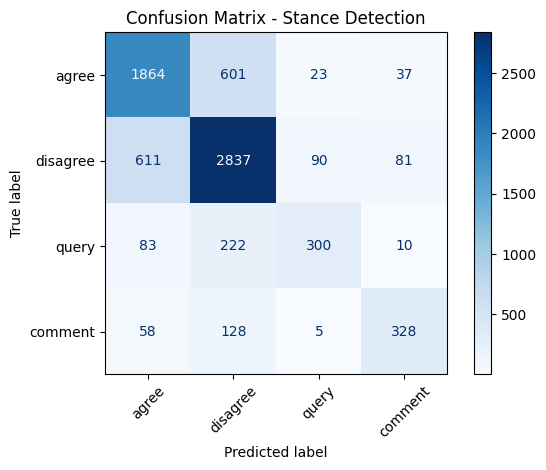

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers.utils import logging
logging.set_verbosity_error()  # Hides tokenizer warnings

stance_model.load_state_dict(torch.load("stance_model.pth"))


# Put model in eval mode
stance_model.eval()

def evaluate_model(dataloader, dataset_name):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = stance_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"📊 {dataset_name} Evaluation:")
    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")

    # Confusion matrix for validation only
    if dataset_name == "Validation Set":
        label_names = ["agree", "disagree", "query", "comment"]
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title("Confusion Matrix - Stance Detection")
        plt.tight_layout()
        plt.show()

# Evaluate on training set
evaluate_model(train_loader, "Training Set")

# Evaluate on validation set
evaluate_model(val_loader, "Validation Set")


In [ ]:
# ------------------ 5. Aggregate Stance Counts ------------------
stance_model.eval()
post_stance = {}

for idx, row in tqdm(data.iterrows(), total=len(data)):
    # Explicitly convert to string
    enc = tokenizer(str(row['post-title']), str(row['commenttext']), return_tensors="pt", truncation=True, padding='max_length', max_length=512)
    input_ids = enc['input_ids'].to(device)
    attn = enc['attention_mask'].to(device)
    with torch.no_grad():
        pred = torch.argmax(stance_model(input_ids, attn), dim=1).item()
    pid = row['post-id']
    if pid not in post_stance:
        post_stance[pid] = [0] * 4
    post_stance[pid][pred] += 1

100%|████████████████████████████████████████████████████████████████████████████| 36386/36386 [32:21<00:00, 18.74it/s]


In [ ]:
import pandas as pd

# Create a DataFrame for stance aggregation from the post_stance dictionary
# We need to reshape the data from the dictionary into a suitable format for a DataFrame
stance_data = []
for pid, counts in post_stance.items():
    # Find the corresponding post-label (veracity) for the post-id from the posts_df
    # We need to handle cases where a post_id from post_stance might not be in posts_df
    post_info = posts_df[posts_df['post-id'] == pid]
    if not post_info.empty:
        # Assuming 'event_id' and 'post-id' columns exist in posts_df
        # Replace 'event_id' with the actual column name if different
        event_id = post_info['event_id'].values[0] if 'event_id' in post_info.columns else None # Replace 'event_id' if necessary
        stance_data.append({
            "event_id": event_id,
            "post_id": pid,
            "stance_agree": counts[stance_le.transform(['agree'])[0]] if 'agree' in stance_le.classes_ else 0,
            "stance_disagree": counts[stance_le.transform(['disagree'])[0]] if 'disagree' in stance_le.classes_ else 0,
            "stance_query": counts[stance_le.transform(['query'])[0]] if 'query' in stance_le.classes_ else 0,
            "stance_comment": counts[stance_le.transform(['comment'])[0]] if 'comment' in stance_le.classes_ else 0
        })

stance_agg_df = pd.DataFrame(stance_data)


# Save stance counts to CSV
stance_agg_df.to_csv("aggregated_stance_counts.csv", index=False)
print("✅ Aggregated stance counts saved to 'aggregated_stance_counts.csv'")

✅ Aggregated stance counts saved to 'aggregated_stance_counts.csv'


In [ ]:
# ------------------ 6. Train Veracity Model ------------------
class VeracityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'x': torch.tensor(self.features[idx], dtype=torch.float32),
            'y': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class VeracityModel(nn.Module):
    def __init__(self, input_dim=4):
        super().__init__()
        self.bert_embed = nn.Linear(input_dim, 16)
        self.lstm = nn.LSTM(16, 32, batch_first=True)
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = self.bert_embed(x).unsqueeze(1)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1])

X, Y = [], []
for pid, counts in post_stance.items():
    label = posts_df[posts_df['post-id'] == pid]['post-label'].values
    if len(label) == 0:
        continue
    Y.append(veracity_le.transform(label)[0])
    X.append(counts)

X = np.array(X)
Y = np.array(Y)

vx_train, vx_val, vy_train, vy_val = train_test_split(X, Y, test_size=0.2, random_state=42)

ver_train = VeracityDataset(vx_train, vy_train)
ver_val = VeracityDataset(vx_val, vy_val)

ver_loader = DataLoader(ver_train, batch_size=16, shuffle=True)
val_loader = DataLoader(ver_val, batch_size=16)

v_model = VeracityModel().to(device)
opt = torch.optim.Adam(v_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    v_model.train()
    for batch in ver_loader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        out = v_model(x)
        loss = loss_fn(out, y)
        opt.zero_grad()
        loss.backward()
        opt.step()


In [ ]:
# ------------------ 7. Evaluate ------------------
v_model.eval()
preds, true = [], []
for batch in val_loader:
    x = batch['x'].to(device)
    y = batch['y'].to(device)
    with torch.no_grad():
        logits = v_model(x)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
    preds.extend(pred)
    true.extend(y.cpu().numpy())

print("✅ Accuracy:", accuracy_score(true, preds))
print("✅ F1 Score:", f1_score(true, preds))


✅ Accuracy: 0.6822429906542056
✅ F1 Score: 0.5853658536585366
